<a href="https://colab.research.google.com/github/Jaseelkt007/ML/blob/master/Diabetic_Retinopathy_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


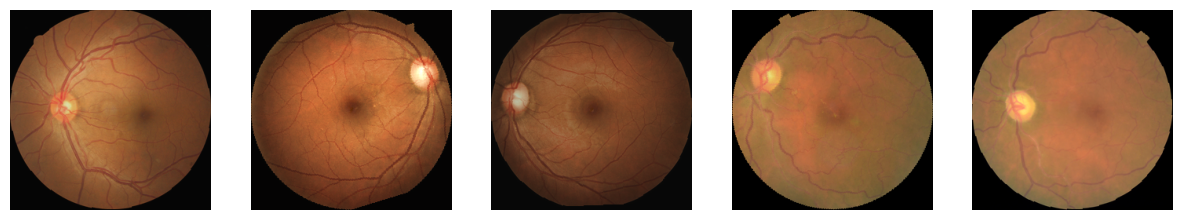

In [15]:
import torchvision.transforms as transforms
import numpy as np
from PIL import Image
from multiprocessing import Pool
import warnings
from tqdm
import os
import torch
import matplotlib.pyplot as plt
import cv2

sample_data_path = '/content/drive/MyDrive/sample'

transform = transforms.Compose([
    #transforms.Resize((256,256)),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness= 0.2, contrast = 0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456,0.406], std= [0.229,0.224,0.225])
])

def trim(image):

    percentage = 0.02
    img = np.array(image)
    img_gray = cv2.cvtColor(img , cv2.COLOR_BGR2GRAY) # Convert to grayscale to simply the process
    # create the binary mask , to get the background from actual content
    img_gray = img_gray > 0.1 * np.mean(img_gray[img_gray!=0])
    # calculate the row wise and column wise sums to find where the significant content exists
    row_sums = np.sum(img_gray, axis = 1)
    col_sums = np.sum(img_gray, axis = 0)
    rows = np.where(row_sums > img.shape[1] * percentage)[0] # return the rows index of rows which contain atleast 2% of its content
    cols = np.where (col_sums > img.shape[0] * percentage)[0]
    # find the min and max rows and columns for croping
    min_row, min_col = np.min(rows), np.min(cols)
    max_row, max_col = np.max(rows), np.max(cols)
    im_crop = img[min_row : max_row +1 , min_col : max_col+1]
    return Image.fromarray(im_crop)

def resize_main_aspect(image, desired_size):
    old_size = image.size
    ratio = float(desired_size)/ max(old_size) # resize ratio
    new_size = tuple([int(x * ratio) for x in old_size]) # (N,M) N,M are new size
    im = image.resize(new_size, Image.LANCZOS) # a filter to smooth image when resize, helps to reduce artifacts in the reduced image
    new_im = Image.new("RGB", (desired_size, desired_size))
    new_im.paste(im, ((desired_size - new_size[0])//2 , (desired_size - new_size[1])//2)) # paster the image on the new square background
    return new_im

def sav_single(args): # helpfull for multiprocessing
    img_file, input_path_folder, output_path_folder, output_size = args
    image_org = Image.open(os.path.join(input_path_folder, img_file))
    image = trim(image_org)
    image = resize_main_aspect(image, desired_size= output_size[0])
    image.save(os.path.join(output_path_folder , img_file))

def multi_image_resize(input_path_folder, output_path_folder, output_size = (None)):
    # Use multiprocessing to make it fast
    if not output_size:
        warnings.warn("Need to specify output size")
        exit()

def preprocess_images(data_path, transform):
    processed_images = []
    for img_name in os.listdir(data_path):
        img_path = os.path.join(data_path, img_name)
        image = Image.open(img_path)
        image = trim(image)
        image_resized = resize_main_aspect(image, desired_size=256)
        image = transform(image_resized)
        processed_images.append(image)
    return processed_images

processed_images = preprocess_images(sample_data_path, transform)

def show_images(images, n=5):
    fig, axs = plt.subplots(1, n , figsize=(15,5))
    for i , img in enumerate(images[:n]):
        img = img.permute(1,2,0) # change from C, H, W to H, W, C
        img = torch.clamp(img * torch.tensor([0.229,0.224,0.225]) +
                          torch.tensor([0.485,0.456,0.406]), 0,1) # denormalize
        axs[i].imshow(img)
        axs[i].axis("off")
    plt.show()

show_images(processed_images,n=5)





